# Analysing COCO dataset

The COCO dataset is widely used for training visual ML models. We will produce some statistics that will be used later in the defintion of the AttentionNET model that splits between identifying the focus in a picture and identifying the object in the focus.

First we load the modules we will use:

In [2]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import pandas as pd

Based on the examples from COCO gothub we will setup a directory to load the annotation data. Since this is the largest dataset we will use the training 2017 dataset and we will focus on the "instances" classifications. The dataset annotations are pre-downloaded in the `annotations` directory:

In [3]:
dataDir='.'
dataType='train2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)

We now setup a COCO object to deal with the annotations data and to parse it:

In [4]:
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=12.85s)
creating index...
index created!


We can analyse the categories from the annotations file. This is provided in the member `cats` of the `COCO` object. This is a dictionary with the key the category ID and as attributes:
- `name`: the name of the category
- `supercategory`: the name of the supercategory that groups more categories together
- `id`: the ID of the category (again although is already the key of the dictionary):

In [5]:
coco.cats

{1: {'supercategory': 'person', 'id': 1, 'name': 'person'},
 2: {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'},
 3: {'supercategory': 'vehicle', 'id': 3, 'name': 'car'},
 4: {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'},
 5: {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'},
 6: {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'},
 7: {'supercategory': 'vehicle', 'id': 7, 'name': 'train'},
 8: {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'},
 9: {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'},
 10: {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'},
 11: {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'},
 13: {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'},
 14: {'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'},
 15: {'supercategory': 'outdoor', 'id': 15, 'name': 'bench'},
 16: {'supercategory': 'animal', 'id': 16, 'name': 'bird'},
 17: {'supercategory': 'animal', 'id': 17, 'name': 'cat'},

The supercategories can be shown with:

In [6]:
nms = set([cat['supercategory'] for cat in coco.cats.values()])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

COCO supercategories: 
indoor vehicle electronic accessory food kitchen furniture animal person outdoor appliance sports


## Number of images

Let see now how many images we have in this training set. We can use the member `imgs` of the `COCO` object:

In [7]:
len(coco.imgs)

118287

So we have 118,287 images in this dataset. We are interested to see how many annotations (individual objects) are for each image and how they are distributed.

The `imgs` is a dictionary that uses the picture ID as the key and contains the following information about each image:

In [8]:
coco.imgs[391895]

{'license': 3,
 'file_name': '000000391895.jpg',
 'coco_url': 'http://images.cocodataset.org/train2017/000000391895.jpg',
 'height': 360,
 'width': 640,
 'date_captured': '2013-11-14 11:18:45',
 'flickr_url': 'http://farm9.staticflickr.com/8186/8119368305_4e622c8349_z.jpg',
 'id': 391895}

From this list we are interested at this time by the size of the picture (`height` and `width`). Later, when training the models we will put in place we will also have to download the images using the `coco_url` provided so that we can do multiple passes on the dataset during training.

## Annotations

Additionally we have in the `anns` attibute that contains information about the picture. It is a dictionary with key the annotation `id` and then a number of informations related to that annotation:

In [9]:
coco.anns[156]

{'segmentation': [[239.97,
   260.24,
   222.04,
   270.49,
   199.84,
   253.41,
   213.5,
   227.79,
   259.62,
   200.46,
   274.13,
   202.17,
   277.55,
   210.71,
   249.37,
   253.41,
   237.41,
   264.51,
   242.54,
   261.95,
   228.87,
   271.34]],
 'area': 2765.1486500000005,
 'iscrowd': 0,
 'image_id': 558840,
 'bbox': [199.84, 200.46, 77.71, 70.88],
 'category_id': 58,
 'id': 156}

The interesting attributes of an annotation are the `image_id` for which that annotation was created, the `area` that represents the surrounding areas of the `segmentation` in pixels and the `bbox` that is the bounding box for the item.

To get all the annotations for a given image we can use:

In [10]:
an_image_id = 475546

annIds = coco.getAnnIds(imgIds=an_image_id, iscrowd=None)
print(annIds)

[439530, 493130, 499271, 509711, 523544, 662991, 666474, 667097, 667891, 1503979, 1643421, 1720965, 1983599]


And if we want to see the details:

In [11]:
for anno in annIds:
    print(coco.anns[anno])

{'segmentation': [[303.0, 227.0, 303.0, 221.0, 296.0, 215.0, 292.0, 208.0, 297.0, 199.0, 301.0, 189.0, 308.0, 179.0, 316.0, 169.0, 325.0, 166.0, 326.0, 166.0, 323.0, 159.0, 330.0, 141.0, 335.0, 132.0, 339.0, 130.0, 351.0, 131.0, 358.0, 139.0, 359.0, 146.0, 359.0, 158.0, 363.2, 173.05, 371.11, 178.99, 374.41, 182.29, 376.39, 196.14, 377.05, 204.72, 380.35, 213.95, 382.99, 220.55, 384.31, 231.77, 382.33, 237.05, 375.07, 236.39, 370.45, 231.77, 369.79, 225.83, 361.88, 231.11, 348.68, 231.11, 307.78, 235.07, 306.46, 229.79, 303.16, 223.19]], 'area': 5945.7057, 'iscrowd': 0, 'image_id': 475546, 'bbox': [292.0, 130.0, 92.31, 107.05], 'category_id': 1, 'id': 439530}
{'segmentation': [[413.5, 228.18, 415.38, 220.2, 416.32, 212.21, 415.85, 200.0, 413.5, 196.24, 411.62, 192.48, 413.5, 188.73, 421.01, 184.97, 425.71, 181.21, 429.0, 177.45, 431.82, 173.69, 429.47, 165.71, 429.47, 156.32, 429.47, 153.03, 431.35, 148.8, 436.98, 145.04, 442.62, 140.81, 448.73, 138.47, 460.47, 138.94, 467.51, 143.16, 

Let's try to have a better understanding of the annotations across the whole dataset. We will count the number of annotations for all images and then we will display a histogram:

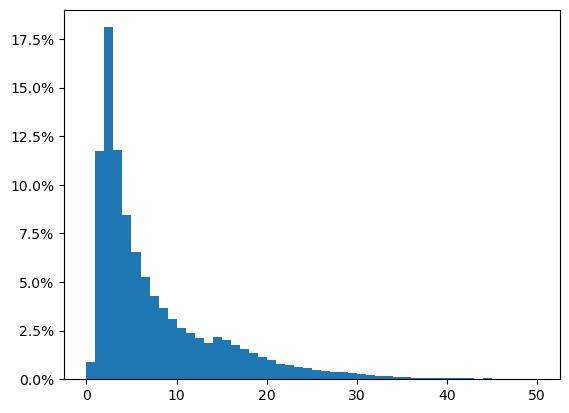

In [12]:
no_anno = []
for img in coco.imgs.values():
    ann = coco.getAnnIds(imgIds=img['id'], iscrowd=None)
    no_anno.append(len(ann))

plt.hist(no_anno, bins=50, range=(0,50), density=True)
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))
plt.show()

Or in a cummulative fashion:

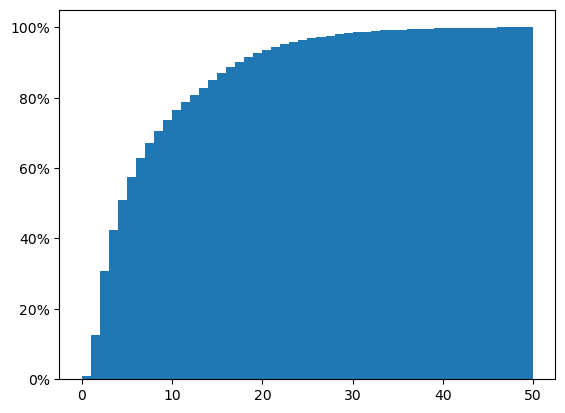

In [13]:
plt.hist(no_anno, bins=50, range=(0,50), density=True, cumulative=True)
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))
plt.show()

## Items in Images (annotations)

One of the characteristics of the annotated items in a picture is that they tend to cover a significantly smaller portion of the image than the whole area of the picture. For example, for the `an_image_id` we selected earlier, if we extract all the annotations and the associated `area` and compare that with the overall area of the image we will get the following results:

In [14]:
an_img = coco.imgs[an_image_id]
image_area = an_img['height'] * an_img['width']

for anno in annIds:
    item_categ_id = coco.anns[anno]['category_id']
    item_area = coco.anns[anno]['area']
    item_area_perc = item_area / image_area * 100
    print(f"category: {coco.cats[item_categ_id]['name']}, area: {item_area:.1f} ({item_area_perc:.2f}%)")

category: person, area: 5945.7 (3.17%)
category: person, area: 3851.8 (2.05%)
category: person, area: 5099.0 (2.72%)
category: person, area: 5632.7 (3.00%)
category: person, area: 24938.9 (13.30%)
category: wine glass, area: 252.6 (0.13%)
category: wine glass, area: 297.1 (0.16%)
category: wine glass, area: 194.0 (0.10%)
category: wine glass, area: 190.2 (0.10%)
category: cup, area: 302.9 (0.16%)
category: sink, area: 3372.5 (1.80%)
category: person, area: 1172.8 (0.63%)
category: refrigerator, area: 7863.8 (4.19%)


As you can see the majority of the items identified in the picture are less than 3% of the whole image, with only one element covering 13.3%. This is clearly visible if we display the corresponding image and the annotations:

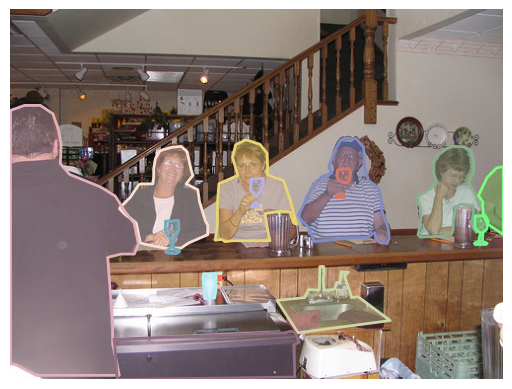

In [15]:
I = io.imread(coco.imgs[an_image_id]['coco_url'])
plt.imshow(I)
plt.axis('off')
coco.showAnns(coco.loadAnns(annIds))

We will perform the above calculations for each picture in the set and put the resulting data into a Panda frame for easier manipulation.

In [26]:
df = pd.DataFrame(coco.anns.values(), index=coco.anns.keys())

In [27]:
df

,segmentation,area,iscrowd,image_id,bbox,category_id,id
156,"[[239.97, 260.24, 222.04, 270.49, 199.84, 253....",2765.14865,0,558840,"[199.84, 200.46, 77.71, 70.88]",58,156
509,"[[247.71, 354.7, 253.49, 346.99, 276.63, 337.3...",1545.42130,0,200365,"[234.22, 317.11, 149.39, 38.55]",58,509
603,"[[274.58, 405.68, 298.32, 405.68, 302.45, 402....",5607.66135,0,200365,"[239.48, 347.87, 160.0, 57.81]",58,603
918,"[[296.65, 388.33, 296.65, 388.33, 297.68, 388....",0.00000,0,200365,"[296.65, 388.33, 1.03, 0.0]",58,918
1072,"[[251.87, 356.13, 260.13, 343.74, 300.39, 335....",800.41325,0,200365,"[251.87, 333.42, 125.94, 22.71]",58,1072
...,...,...,...,...,...,...,...
900100390883,"{'counts': [13254, 1, 316, 4, 6, 1, 315, 7, 31...",4227.00000,1,390883,"[40, 104, 394, 43]",1,900100390883
905300049902,"{'counts': [68786, 6, 492, 9, 494, 7, 497, 4, ...",6058.00000,1,49902,"[137, 195, 140, 138]",53,905300049902
904300363764,"{'counts': [203528, 6, 420, 8, 418, 10, 416, 1...",737.00000,1,363764,"[476, 200, 153, 85]",43,904300363764
900100554743,"{'counts': [99015, 6, 352, 8, 350, 9, 322, 11,...",6478.00000,1,554743,"[275, 207, 153, 148]",1,900100554743


Let's make sure that the numbers match the previously calculated number of annotations per image:

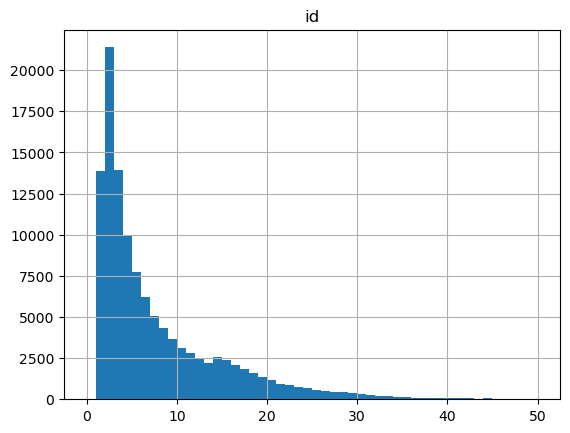

In [55]:
df[['image_id', 'id']].groupby(by="image_id").count().hist(bins=50, range=(0,50))
plt.show()

They seem to be the same. Let's add now the image area and the percentage of annotated item in the image:

In [42]:
df['image_height'] = df.apply(lambda x: coco.imgs[x['image_id']]['height'], axis=1)
df['image_width'] = df.apply(lambda x: coco.imgs[x['image_id']]['width'], axis=1)
df['image_area'] = df['image_height'] * df['image_width']
df['anno_area_perc'] = df['area'] / df['image_area'] * 100

Let's see the results:

In [44]:
df

,segmentation,area,iscrowd,image_id,bbox,category_id,id,image_height,image_width,image_area,anno_area_perc
156,"[[239.97, 260.24, 222.04, 270.49, 199.84, 253....",2765.14865,0,558840,"[199.84, 200.46, 77.71, 70.88]",58,156,427,640,273280,1.011837
509,"[[247.71, 354.7, 253.49, 346.99, 276.63, 337.3...",1545.42130,0,200365,"[234.22, 317.11, 149.39, 38.55]",58,509,480,640,307200,0.503067
603,"[[274.58, 405.68, 298.32, 405.68, 302.45, 402....",5607.66135,0,200365,"[239.48, 347.87, 160.0, 57.81]",58,603,480,640,307200,1.825411
918,"[[296.65, 388.33, 296.65, 388.33, 297.68, 388....",0.00000,0,200365,"[296.65, 388.33, 1.03, 0.0]",58,918,480,640,307200,0.000000
1072,"[[251.87, 356.13, 260.13, 343.74, 300.39, 335....",800.41325,0,200365,"[251.87, 333.42, 125.94, 22.71]",58,1072,480,640,307200,0.260551
...,...,...,...,...,...,...,...,...,...,...,...
900100390883,"{'counts': [13254, 1, 316, 4, 6, 1, 315, 7, 31...",4227.00000,1,390883,"[40, 104, 394, 43]",1,900100390883,328,500,164000,2.577439
905300049902,"{'counts': [68786, 6, 492, 9, 494, 7, 497, 4, ...",6058.00000,1,49902,"[137, 195, 140, 138]",53,905300049902,500,375,187500,3.230933
904300363764,"{'counts': [203528, 6, 420, 8, 418, 10, 416, 1...",737.00000,1,363764,"[476, 200, 153, 85]",43,904300363764,427,640,273280,0.269687
900100554743,"{'counts': [99015, 6, 352, 8, 350, 9, 322, 11,...",6478.00000,1,554743,"[275, 207, 153, 148]",1,900100554743,359,640,229760,2.819464


And let's plot a histogram with these percentages:

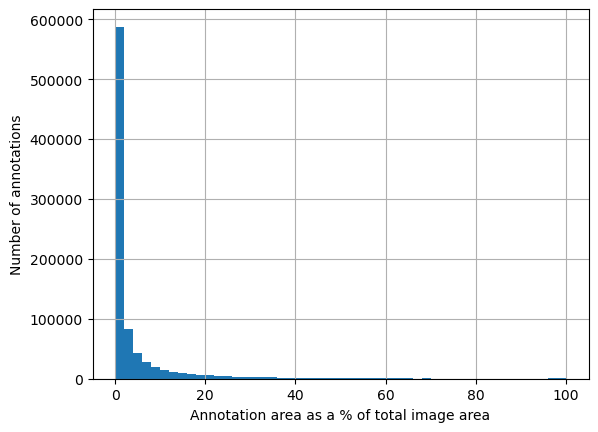

In [53]:
df['anno_area_perc'].hist(bins=50, range=(0,100))
plt.gca().set_ylabel('Number of annotations')
plt.gca().set_xlabel('Annotation area as a % of total image area')
plt.show()

As expected the vast majority is bellow 10%. Let's focus on that part:

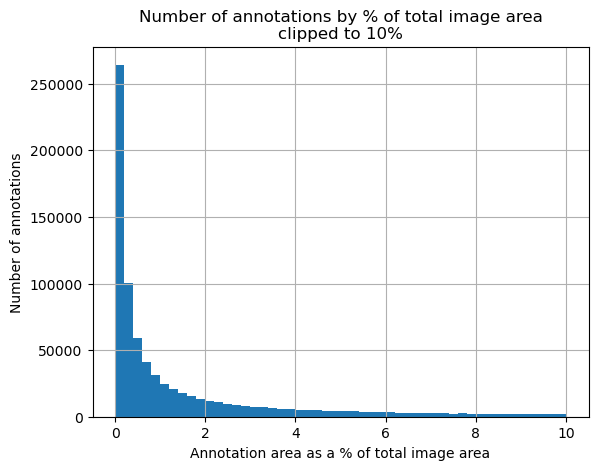

In [63]:
df['anno_area_perc'].hist(bins=50, range=(0,10))
plt.gca().set_ylabel('Number of annotations')
plt.gca().set_xlabel('Annotation area as a % of total image area')
plt.title('Number of annotations by % of total image area\nclipped to 10%')
plt.show()

A cumulative histogram with % of all annotation will give an even better perpective:

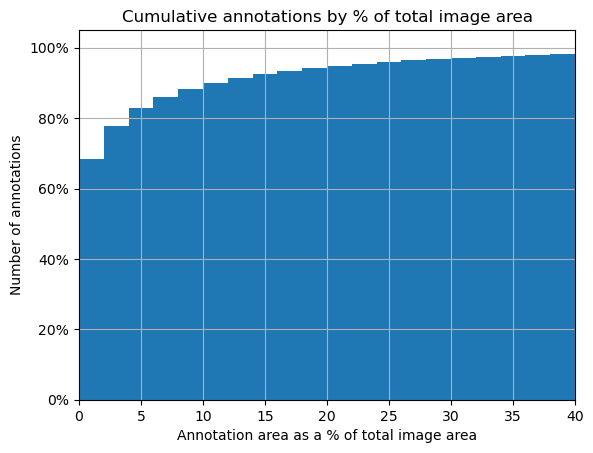

In [62]:
df['anno_area_perc'].hist(bins=50, range=(0,100), density=True, cumulative=True)
plt.gca().set_ylabel('Number of annotations')
plt.gca().set_xlabel('Annotation area as a % of total image area')
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))
plt.xlim(left=0, right=40)
plt.title('Cumulative annotations by % of total image area')
plt.show()

In [16]:
dir(coco)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'annToMask',
 'annToRLE',
 'anns',
 'catToImgs',
 'cats',
 'createIndex',
 'dataset',
 'download',
 'getAnnIds',
 'getCatIds',
 'getImgIds',
 'imgToAnns',
 'imgs',
 'info',
 'loadAnns',
 'loadCats',
 'loadImgs',
 'loadNumpyAnnotations',
 'loadRes',
 'showAnns']

## Biography

[1]T.-Y. Lin et al., ‘Microsoft COCO: Common Objects in Context’, arXiv:1405.0312 [cs], Feb. 2015, Accessed: May 05, 2021. [Online]. Available: http://arxiv.org/abs/1405.0312.
